In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
import os
import cv2
import numpy as np
from imutils import paths

In [ ]:
from sklearn.preprocessing import LabelBinarizer

In [ ]:
dataPath = '/content/drive/MyDrive/Dataset'
outputModel= '/content/drive/MyDrive/output/videoOutput'
outputLabels = '/content/drive/MyDrive/output/labelsOutput'
epoch = 3

In [ ]:
sports_labels = set(['football', 'swimming', 'table_tennis', 'boxing', 'chess', 'weight_lifting'])
print('images is being loaded...')
pathToImages = list(paths.list_images(dataPath))
data = []
labels = []
for images in pathToImages:
  label = images.split(os.path.sep)[-2]
  if label not in sports_labels:
    continue
  image = cv2.imread(images)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, (244,244))
  data.append(image)
  labels.append(label)

images is being loaded...


In [ ]:
data = np.array(data)
labels = np.array(labels)
# hot encoded values 0, 1, 2, 3, 4, 5
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels, test_size=0.25, stratify=labels, random_state=42)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
trainingAugmentation = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

validationAugmentation = ImageDataGenerator()
mean = np.array([123.68, 116.779, 103.939])
trainingAugmentation.mean = mean
validationAugmentation.mean = mean


In [ ]:
from keras.applications import ResNet50

from keras.layers import Input
from keras.layers import AveragePooling2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense

from keras.layers import Dropout

from keras.models import Model

In [ ]:
baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 244, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
# headModel = MaxPool2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(lb.classes_), activation="softmax")(headModel) # probavilty distr
model = Model(inputs=baseModel.input, outputs=headModel)

for baseModelLayers in baseModel.layers:
  baseModelLayers.trainable = False

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
from keras.optimizers import Adam

In [ ]:
opt = Adam(learning_rate=1e-4) # decay!!

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
History = model.fit_generator(
    trainingAugmentation.flow(X_train, Y_train, batch_size=32),
    steps_per_epoch=len(X_train) // 32,
    validation_data = validationAugmentation.flow(X_test, Y_test),
    validation_steps = len(X_test) // 32,
    epochs = epoch
)



<ipython-input-16-ba7cee614fe4>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  History = model.fit_generator(


92/92 [==============================] - 62s 556ms/step - loss: 4.2531 - accuracy: 0.5048 - val_loss: 0.5584 - val_accuracy: 0.8448


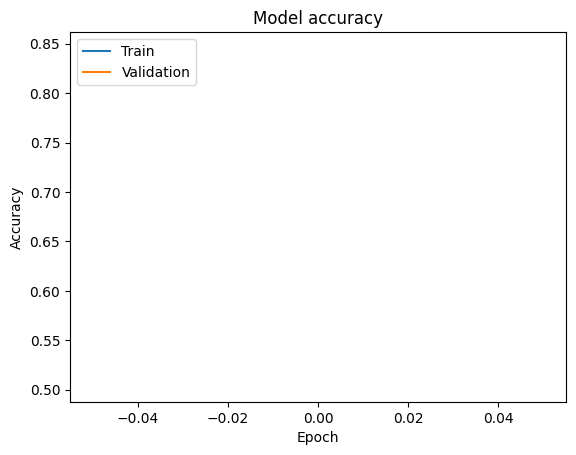

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
import pickle
model.save(outputModel)
lbinarizer = open("/content/drive/MyDrive/output/labelsOutput.pickle", "wb")
lbinarizer.write(pickle.dumps(lb))
lbinarizer.close()